**Tested library versions**

- json version: 2.0.9
- numpy version: 1.24.3
- matplotlib version: 3.8.0
- BioPython version: 1.78

In [9]:
import os
import re
import json
import warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import Counter
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 75 # change this for high resolution output


warnings.filterwarnings('ignore')
np.seterr(divide='ignore', invalid='ignore')

def transform_pae_matrix(pae_matrix, pae_cutoff):
    # Initialize the transformed matrix with zeros
    transformed_pae = np.zeros_like(pae_matrix)

    # Apply transformation: pae = 0 -> score = 1, pae = cutoff -> score = 0, above cutoff -> score = 0
    # Linearly scale values between 0 and cutoff to fall between 1 and 0
    within_cutoff = pae_matrix < pae_cutoff
    transformed_pae[within_cutoff] = 1 - (pae_matrix[within_cutoff] / pae_cutoff)
    
    return transformed_pae

def calculate_mean_lis(transformed_pae, subunit_number):
    # Calculate the cumulative sum of protein lengths to get the end indices of the submatrices
    cum_lengths = np.cumsum(subunit_number)
    
    # Add a zero at the beginning of the cumulative lengths to get the start indices
    start_indices = np.concatenate(([0], cum_lengths[:-1]))
    
    # Initialize an empty matrix to store the mean LIS
    mean_lis_matrix = np.zeros((len(subunit_number), len(subunit_number)))
    
    # Iterate over the start and end indices
    for i in range(len(subunit_number)):
        for j in range(len(subunit_number)):
            # Get the start and end indices of the interaction submatrix
            start_i, end_i = start_indices[i], cum_lengths[i]
            start_j, end_j = start_indices[j], cum_lengths[j]
            
            # Get the interaction submatrix
            submatrix = transformed_pae[start_i:end_i, start_j:end_j]
            
            # Calculate the mean LIS, considering only non-zero values
            mean_lis = submatrix[submatrix > 0].mean()
            
            # Store the mean LIS in the matrix
            mean_lis_matrix[i, j] = mean_lis
    
    return mean_lis_matrix

def afm3_plot(af3_json, pae_cutoff=12):
    model_number = re.search(r'full_data_(\d+)', af3_json).group(1)
    json_data = json.load(open(af3_json,'rb'))
    token_chain_ids = json_data['token_chain_ids']
    chain_residue_counts = Counter(token_chain_ids)
    subunit_number = list(chain_residue_counts.values())    
    pae_matrix = np.array(json_data['pae'])
    pae_matrix = np.nan_to_num(pae_matrix)
    subunit_sizes = subunit_number
    boundaries = np.cumsum(subunit_sizes)

    # Create a figure with 1 row and 3 columns
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plotting the PAE matrix
    cax1 = axs[0].matshow(pae_matrix, cmap='bwr')
    for boundary in boundaries[:-1]:
        axs[0].add_patch(Rectangle((boundary, 0), 0.5, len(pae_matrix), edgecolor='black', fill=False, linewidth=2))
        axs[0].add_patch(Rectangle((0, boundary), len(pae_matrix), 0.5, edgecolor='black', fill=False, linewidth=2))
    fig.colorbar(cax1, ax=axs[0], label='Predicted Aligned Error (PAE)', shrink=0.5)
    axs[0].set_title(f'Model {model_number} Predicted Aligned Error Map')
    axs[0].xaxis.tick_bottom()

    # Transform the PAE matrix
    transformed_pae_matrix = transform_pae_matrix(pae_matrix, pae_cutoff)
    transformed_pae_matrix = np.nan_to_num(transformed_pae_matrix)
    boundaries = np.cumsum(subunit_sizes)

    # Plotting the transformed PAE matrix
    cax2 = axs[1].matshow(transformed_pae_matrix, cmap='Blues', vmin=0, vmax=1)
    for boundary in boundaries[:-1]:
        axs[1].add_patch(Rectangle((boundary, 0), 0.5, len(pae_matrix), edgecolor='black', fill=False, linewidth=2))
        axs[1].add_patch(Rectangle((0, boundary), len(pae_matrix), 0.5, edgecolor='black', fill=False, linewidth=2))
    fig.colorbar(cax2, ax=axs[1], label='Local Interaction Score (LIS)', shrink=0.5)
    axs[1].set_title(f'Model {model_number} Local Interaction Area Map')
    axs[1].xaxis.tick_bottom()

    # Calculate the mean LIS matrix
    mean_lis_matrix = calculate_mean_lis(transformed_pae_matrix, subunit_sizes)
    mean_lis_matrix = np.nan_to_num(mean_lis_matrix)

    # Plot the mean LIS matrix as a heatmap
    cax3 = axs[2].imshow(mean_lis_matrix, cmap='magma_r', interpolation='nearest', vmin=0, vmax=1)
    fig.colorbar(cax3, ax=axs[2], label='Local Interaction Score (LIS)', shrink=0.5)
    axs[2].set_title(f'Model {model_number} Local Interaction Score Heatmap')
    subunit_labels = [i for i in range(1, len(subunit_sizes)+1)]
    axs[2].set_xticks(np.arange(len(subunit_sizes)))
    axs[2].set_yticks(np.arange(len(subunit_sizes)))
    axs[2].set_xticklabels(subunit_labels)
    axs[2].set_yticklabels(subunit_labels)

    for i in range(len(subunit_sizes)):
        for j in range(len(subunit_sizes)):
            value = mean_lis_matrix[i, j]
            text_color = 'w' if value > 0.5 else 'k'  
            axs[2].text(j, i, format(mean_lis_matrix[i, j], '.3f'), ha='center', va='center', color=text_color)

    plt.tight_layout()
    plt.show()

def generate_json_paths(base_path, number_of_models=5):
    """
    Generates a list of JSON file paths for a given number of models within a specified base path.

    Parameters:
    - base_path (str): The base directory where the model JSON files are stored.
    - number_of_models (int): The number of model JSON files to generate paths for.

    Returns:
    - list: A list of fully qualified paths to the JSON files.
    """
    model_identifier = os.path.basename(base_path)
    json_files = [f"{base_path}/{model_identifier}_full_data_{model}.json" for model in range(number_of_models)]
    return json_files

def afm3_plot_average(af3_jsons, pae_cutoff=12):
    # Initialize the sum of PAE matrices, transformed PAE matrices, and mean LIS matrices
    sum_pae_matrix = None
    sum_transformed_pae_matrix = None
    sum_mean_lis_matrix = None

    for af3_json in af3_jsons:
        json_data = json.load(open(af3_json,'rb'))
        token_chain_ids = json_data['token_chain_ids']
        chain_residue_counts = Counter(token_chain_ids)
        subunit_number = list(chain_residue_counts.values())    
        pae_matrix = np.array(json_data['pae'])
        subunit_sizes = subunit_number

        # Transform the PAE matrix
        transformed_pae_matrix = transform_pae_matrix(pae_matrix, pae_cutoff)

        # Calculate the mean LIS matrix
        mean_lis_matrix = calculate_mean_lis(transformed_pae_matrix, subunit_sizes)

        # Add the matrices to the sum
        if sum_pae_matrix is None:
            sum_pae_matrix = pae_matrix
            sum_transformed_pae_matrix = transformed_pae_matrix
            sum_mean_lis_matrix = mean_lis_matrix
        else:
            sum_pae_matrix += pae_matrix
            sum_transformed_pae_matrix += transformed_pae_matrix
            sum_mean_lis_matrix += mean_lis_matrix

    # Calculate the average matrices
    avg_pae_matrix = sum_pae_matrix / len(af3_jsons)
    avg_transformed_pae_matrix = sum_transformed_pae_matrix / len(af3_jsons)
    avg_mean_lis_matrix = sum_mean_lis_matrix / len(af3_jsons)

    # Replace nan with 0 
    avg_pae_matrix = np.nan_to_num(avg_pae_matrix)
    avg_transformed_pae_matrix = np.nan_to_num(avg_transformed_pae_matrix)
    avg_mean_lis_matrix = np.nan_to_num(avg_mean_lis_matrix)

    # Create a figure with 1 row and 3 columns
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Calculate the cumulative sum of subunit sizes to get the boundaries
    boundaries = np.cumsum(subunit_sizes)[:-1]

    # Plotting the average PAE matrix
    cax1 = axs[0].matshow(avg_pae_matrix, cmap='bwr')
    fig.colorbar(cax1, ax=axs[0], label='Average Predicted Aligned Error (PAE)', shrink=0.5)
    axs[0].set_title('Average Predicted Aligned Error Map')
    axs[0].xaxis.tick_bottom()

    # Add vertical and horizontal lines at the boundaries
    for boundary in boundaries:
        axs[0].axvline(x=boundary, color='black', linestyle='-')
        axs[0].axhline(y=boundary, color='black', linestyle='-')

    # Plotting the average transformed PAE matrix
    cax2 = axs[1].matshow(avg_transformed_pae_matrix, cmap='Blues', vmin=0, vmax=1)
    fig.colorbar(cax2, ax=axs[1], label='Average Local Interaction Score (LIS)', shrink=0.5)
    axs[1].set_title('Average Local Interaction Area Map')
    axs[1].xaxis.tick_bottom()

    # Add vertical and horizontal lines at the boundaries
    for boundary in boundaries:
        axs[1].axvline(x=boundary, color='black', linestyle='-')
        axs[1].axhline(y=boundary, color='black', linestyle='-')

    # Plot the average mean LIS matrix as a heatmap
    cax3 = axs[2].imshow(avg_mean_lis_matrix, cmap='magma_r', interpolation='nearest', vmin=0, vmax=1)
    fig.colorbar(cax3, ax=axs[2], label='Average Local Interaction Score (LIS)', shrink=0.5)
    axs[2].set_title('Average Local Interaction Score Heatmap')
    subunit_labels = [i for i in range(1, len(subunit_sizes)+1)]
    axs[2].set_xticks(np.arange(len(subunit_sizes)))
    axs[2].set_yticks(np.arange(len(subunit_sizes)))
    axs[2].set_xticklabels(subunit_labels)
    axs[2].set_yticklabels(subunit_labels)

    for i in range(len(subunit_sizes)):
        for j in range(len(subunit_sizes)):
            value = avg_mean_lis_matrix[i, j]
            text_color = 'w' if value > 0.5 else 'k'  
            axs[2].text(j, i, format(value, '.3f'), ha='center', va='center', color=text_color)

    plt.tight_layout()
    plt.show()

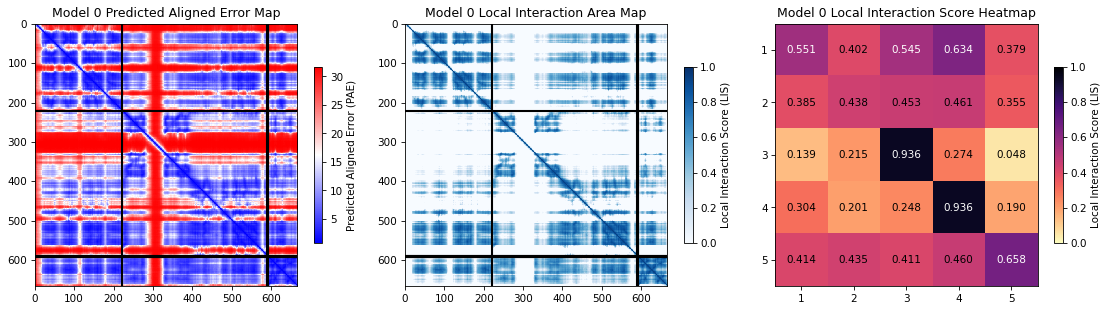

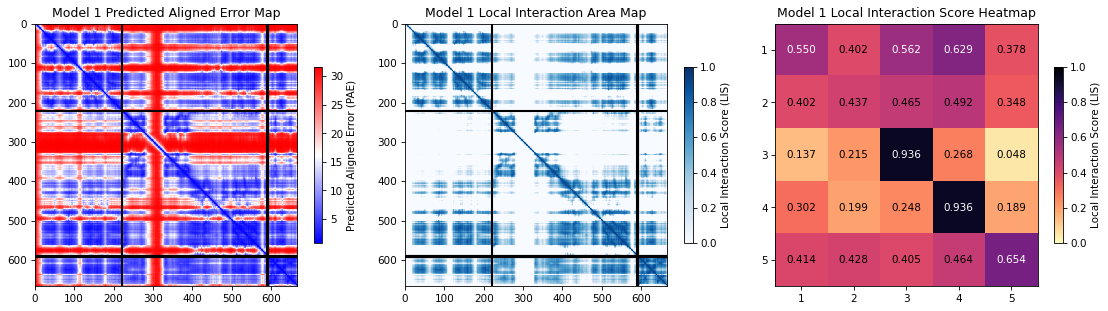

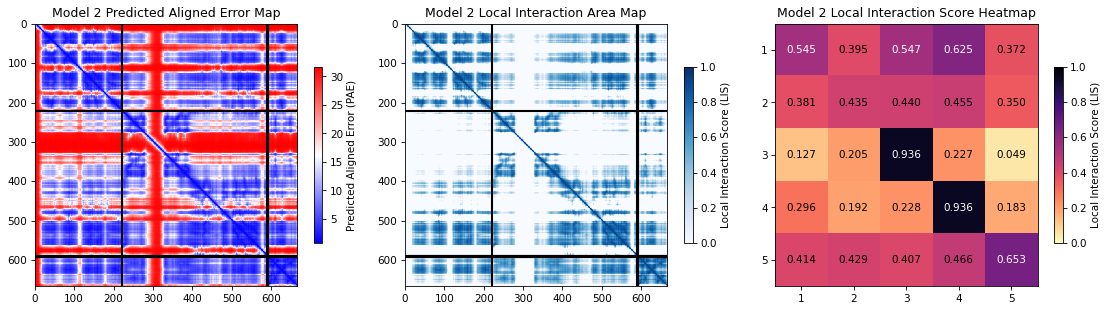

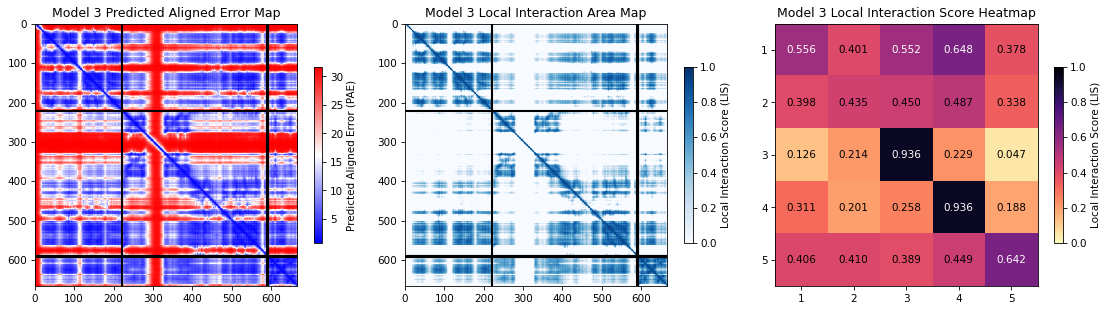

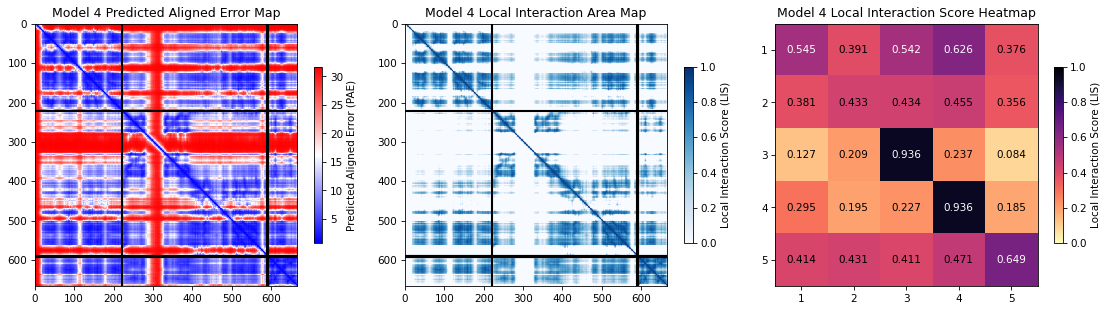

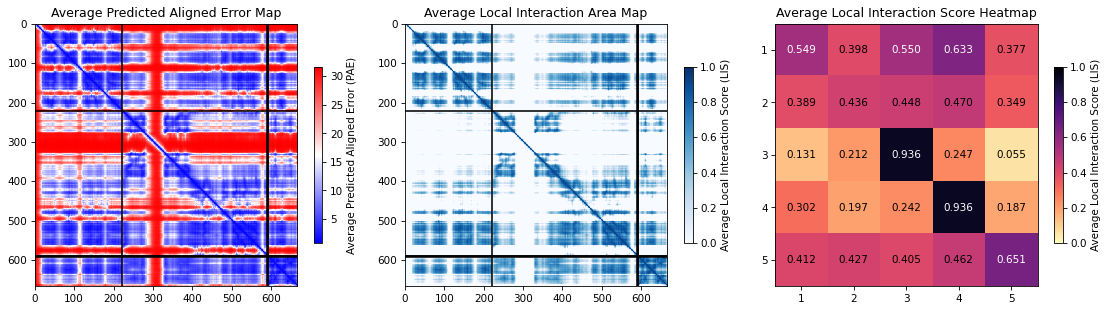

In [10]:
base_path = "/Users/ah-ramkim/alphafold3/examplefold_pdb_8aw3"
json_files = generate_json_paths(base_path, number_of_models=5)
pae_cutoff = 12

for json_file in json_files:
    afm3_plot(json_file, pae_cutoff)
afm3_plot_average(json_files, pae_cutoff)


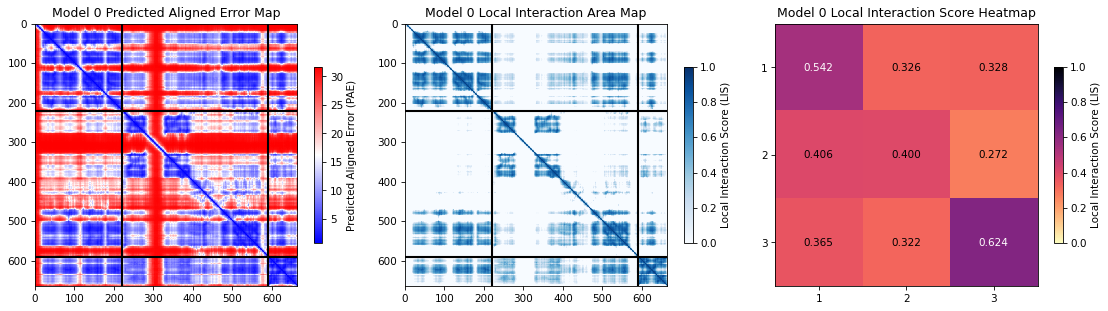

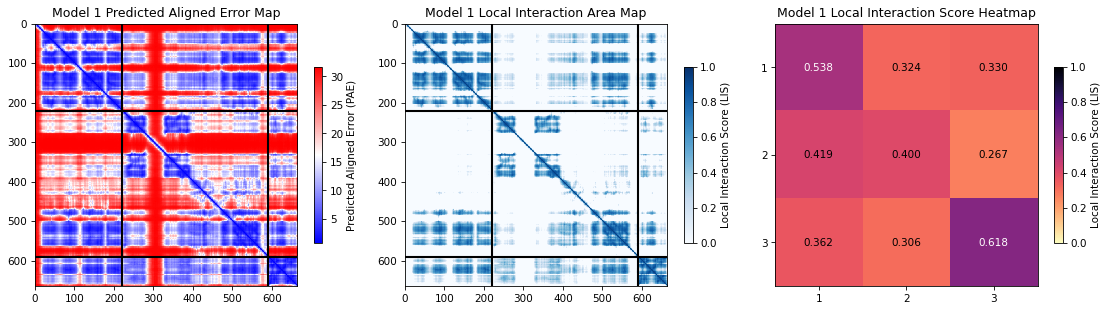

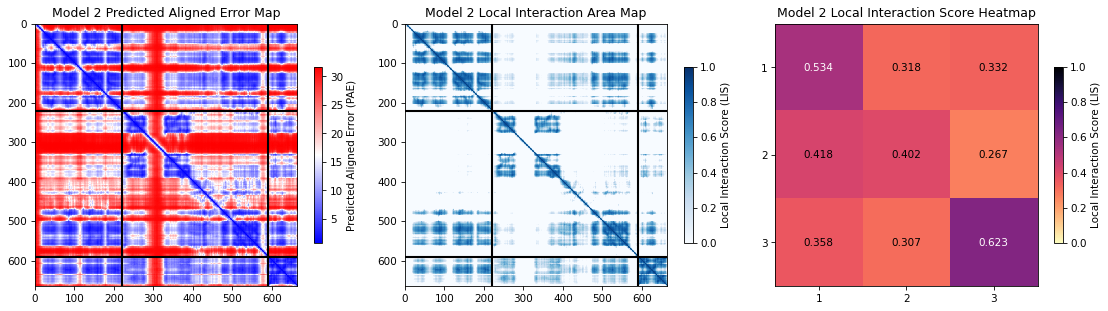

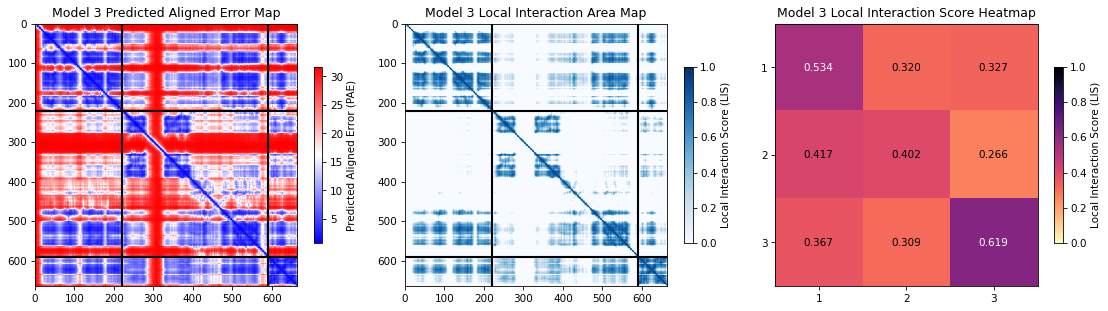

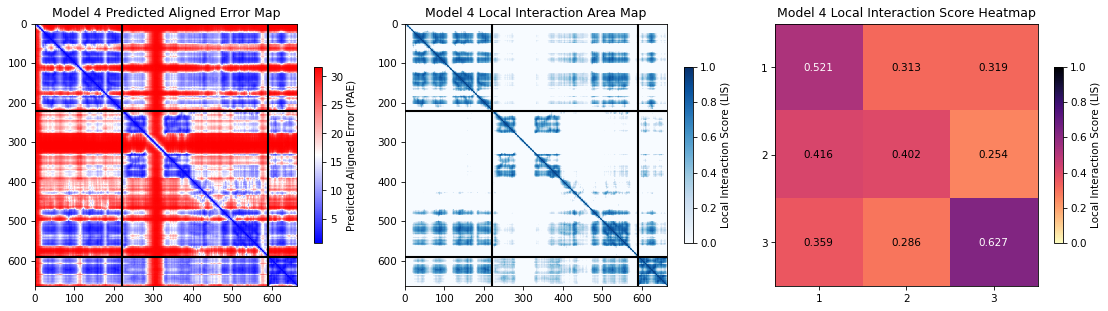

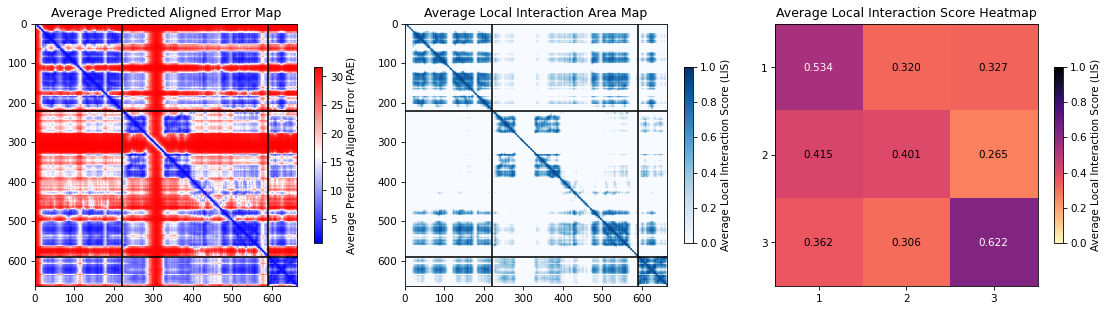

In [11]:
# Loss of Zn2+ ions in the structure of PDB 8aw3 results in a  decrease in the LIS of the protein complex.
base_path = "/Users/ah-ramkim/alphafold3/fold_protein_rna_ion_pdb_8aw3_without_zn_ions"
json_files = generate_json_paths(base_path, number_of_models=5)
pae_cutoff = 12

for json_file in json_files:
    afm3_plot(json_file, pae_cutoff)
afm3_plot_average(json_files, pae_cutoff)


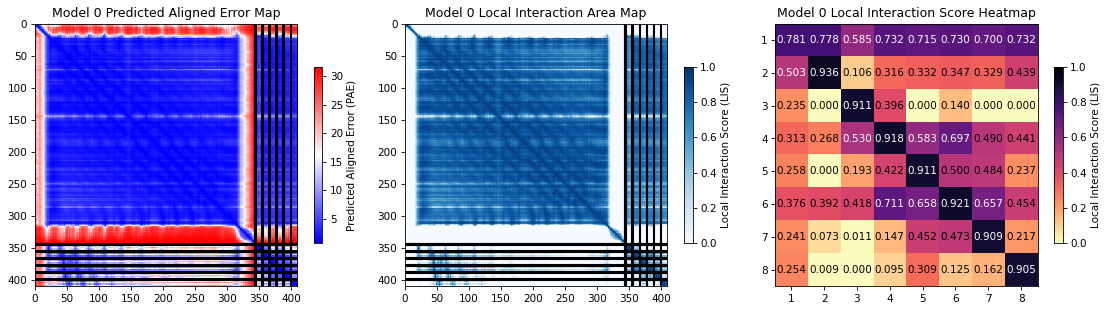

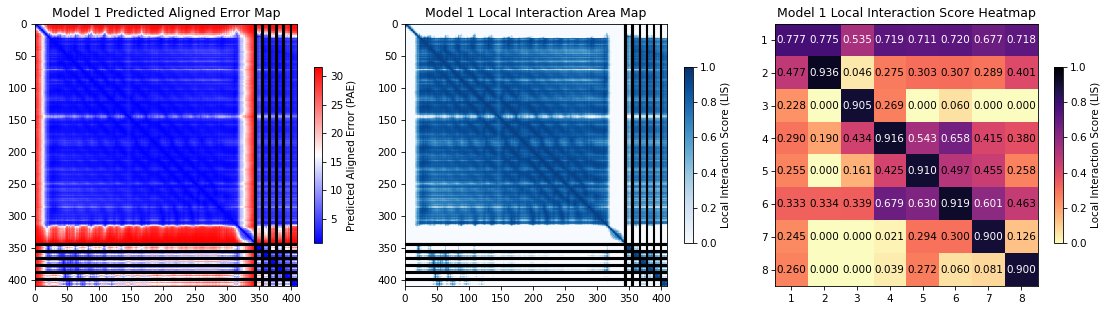

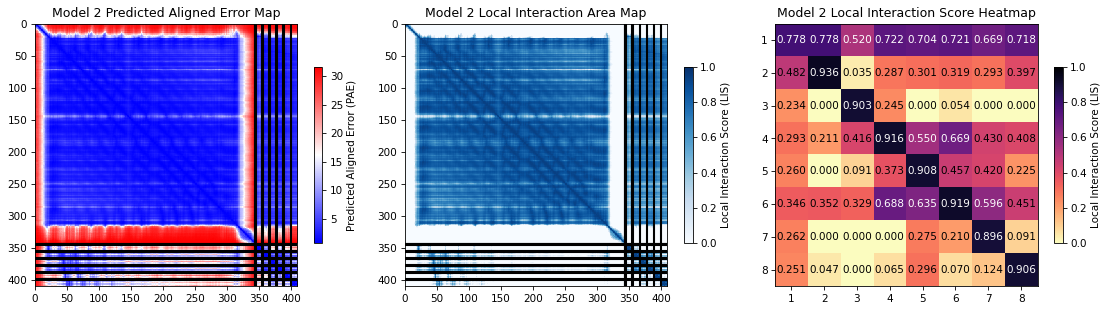

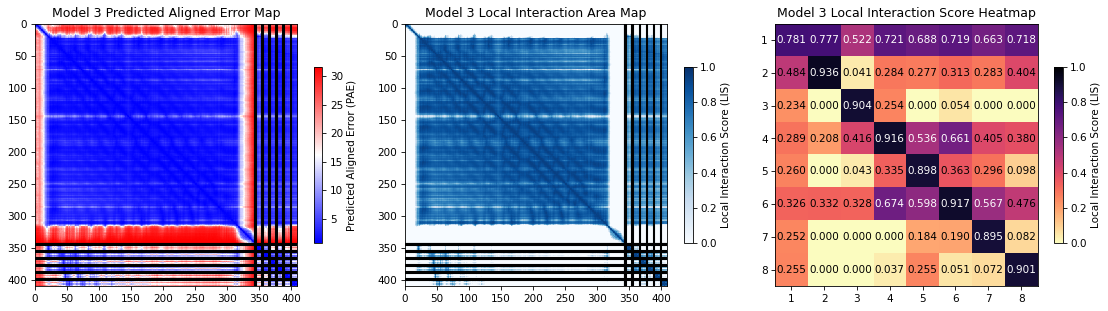

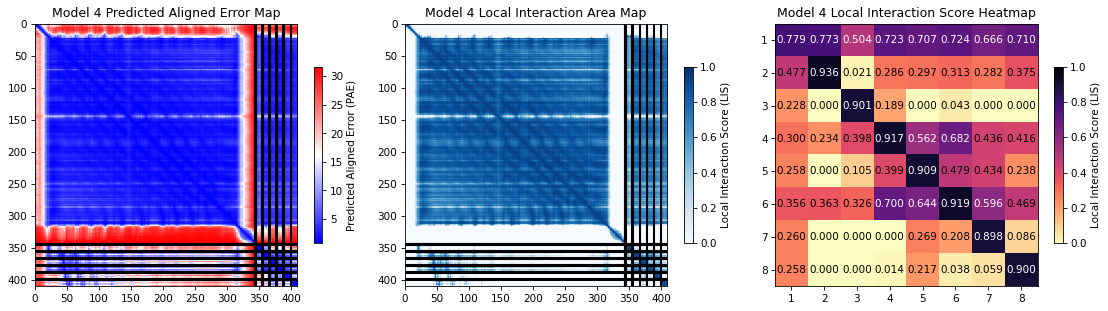

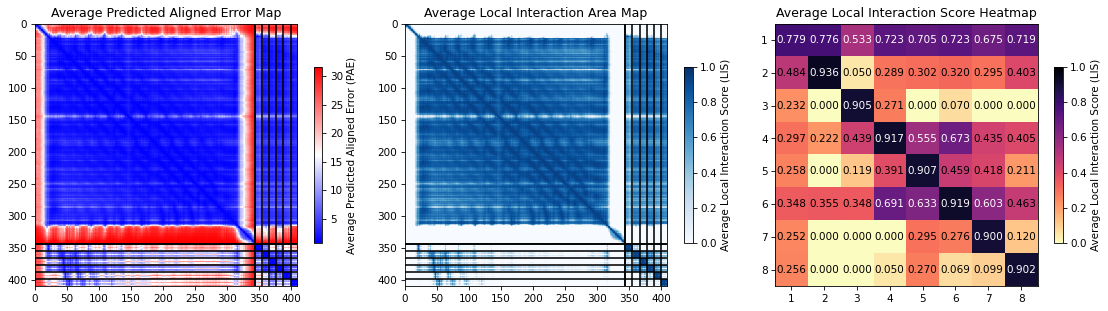

In [12]:
base_path = "/Users/ah-ramkim/alphafold3/examplefold_pdb_7bbv"
json_files = generate_json_paths(base_path, number_of_models=5)
pae_cutoff = 12

for json_file in json_files:
    afm3_plot(json_file, pae_cutoff)
afm3_plot_average(json_files, pae_cutoff)
